# Gambler's Problem

Consider a gamble on a series of coin flips. The goal is to get $100 from a set of capital $s \in \{1, 2, \ldots, 99 \}$ by wagering an action of $a \in \{0, 1, \ldots, \min(s, 100-s) \}$. The reward is zero for all bets until the goal of $100 is reached which gives +1. How much should the gambler bet in each round with their captial?

Given probability of positively flipping a coin $p_h$, the solution can be computed with *value iteration*

$$
V(s) = \max_a \sum_{s'} p(s', r \; | \; s, a) [r + \gamma V(s')].
$$

In English, this equation states the optimal action $a$ in the current state $s$ is the action which lands in the next state $s'$ with reward $r$ along with the discounted reward $\gamma V(s')$. Since each action has several outcomes $p(s' \; | s, a)$, the sum term computes the expected reward from all possible outcomes. Also the equation recursively calls itself $\gamma V(s')$. It's also non-linear because we're chosing the action with maximum expected reward $\max_a$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
capital = list(range(100+1))
def stakes(s):
    return list(range(min(s, 100 - s)+1))

In [4]:
ph = 0.4
gamma = .9

Value iteration complete after 32 steps


Text(0.5, 1.0, "Value Iteration solution for the Gambler's Problem")

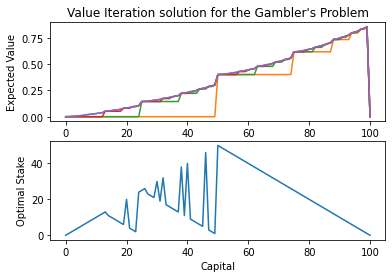

In [5]:
Sn = len(capital)
V = np.zeros(Sn)
policy = np.zeros(Sn)
iter = 0
theta = 0

# save V at iterations 1, 2, 3, 32
Vi = []

while True:
    delta = np.zeros(Sn)
    iter += 1
    for i, s in enumerate(capital):
        if s == 100:
            continue
        actions = stakes(s)
        Vs = np.zeros(len(actions))
        for j, a in enumerate(actions):
            # for each action, the outcomes are only positive if s+a = 100
            r = 0
            # if a + s > 100:
            #     continue  # out of domain condition
            if (a + s) == 100:
                r = 1
                # print(f"Winning combo: {a}+{s}")
            
            Vs[j] = ph * (r + gamma * V[a+s])
            # Add expected reward from tail outcome
            # if s-a > 0:
            Vs[j] += (1 - ph) * (gamma * V[s - a])

        delta[i] = np.abs(V[i] - Vs.max())
        V[i] = Vs.max()
        policy[i] = Vs.argmax()

    if iter in (1, 2, 3, 32):
        Vi.append(V.copy())    
    
    if np.all(delta <= theta):
        print("Value iteration complete after {} steps".format(iter))
        break


fig, axs = plt.subplots(2, 1)
axs[0].plot(capital, V)
for val in Vi:
    axs[0].plot(capital, val)
axs[1].plot(capital, policy)
axs[0].set_ylabel("Expected Value")
axs[1].set_ylabel("Optimal Stake")
axs[1].set_xlabel("Capital")
axs[0].set_title("Value Iteration solution for the Gambler's Problem")

## Frozen Lake

Consider a $4 \times 4$ grid. The environment has 16 possible states $\mathcal S$, and four actions $\mathcal A$: `{0:LEFT, 1:DOWN, 2:RIGHT, 4:UP}`. The transition dynamics $p(s' \; | \; s, a)$ are $1/3$ move in the intended direction, and $1/3$ move orthogonal, *i.e.*, `LEFT` or `RIGHT`, of the intended direction. 

In [6]:
from FrozenLake import FrozenLakeEnv
from collections import Counter

In [7]:
MAP_SIZE="8x8"
if MAP_SIZE == "4x4":
    goal = 15
else:
    goal = 63

actions = {
    0: "LEFT",
    1: "DOWN",
    2: "RIGHT",
    3: "UP"
}

In [8]:
env = FrozenLakeEnv(map_name=MAP_SIZE, is_slippery=True)
env.reset()
env.render()


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


In [9]:
def value_iteration(env, gamma=1, theta=1e-8):
    r"""Policy evaluation function. Loop until state rewards are stable.
    
    Returns: 
        V (np.array): expected state value given an infinite horizon.
        policy (np.array): best action for each state.

    Args:
        env (gym.env): gym environment.
        gamma (float): future reward discount rate.
        theta (float): stopping criterion.
    """
    # Initialize state-value array
    S_n = env.observation_space.n
    V = np.zeros(S_n)
    policy = np.ones(S_n) * -1
    delta = np.zeros(S_n)
    i = 0
    while True:
        i += 1
        # Loop through states
        for s in env.P:
            Vs = np.zeros(len(env.P[s]))
            # Loop through available actions in each state
            for a in env.P[s]:
                # Loop though transition probabilities, next state, and rewards
                for prob, next_state, reward, done in env.P[s][a]:
                    Vs[a] += prob * (reward + gamma * V[next_state])
            delta[s] = np.abs(V[s] - Vs.max())
            V[s] = Vs.max()
            policy[s] = Vs.argmax()
        if np.all(delta < theta):
            print("Value iteration complete after {} steps".format(i))
            break
    return V, policy


In [60]:
Sn = len(env.P)
grid_size = int(np.sqrt(Sn))
env.reset()
V, policy = value_iteration(env, gamma=.9)

# print(np.array2string(V.reshape(grid_size,grid_size), precision=3))
opt_action = np.array([actions[a] for a in policy]).reshape(grid_size,grid_size)
# print(np.array2string(opt_action))


total_reward = 0
episodes = 1000
end_state = []
episode_failures = []
t_max = 100

for i_episode in range(episodes):
    obs = env.reset()
    action_list = []
    state_list = [obs]
    for t in range(t_max):
        # env.render()
        # print(obs)
        action = policy[obs]
        action_list.append(action)
        obs, reward, done, info = env.step(action)  # take an action based on the optimal policy
        state_list.append(obs)
        if done:
            # total_reward += reward
            end_state.append(obs)
            if obs == goal:
                total_reward += 1
                # print ("Made the goal!")
            else:
                # Add the action sequence that produced the bad outcome
                episode_failures.append((state_list, action_list))
                # print("Fell in the hole at ({},{})".format(obs // 4, obs%4))
            # print("Episode {} finished after {} timeteps. Reward {}.".format(
                # i_episode+1, t+1, reward))
            break
        elif t == t_max-1:
            # Out of time
            end_state.append(obs)
env.close()
print(f"Reward percentage {total_reward/episodes}")

histogram = Counter(end_state)
# locs = [f"({idx // grid_size}, {idx % grid_size})" for idx in histogram.keys()]
# plt.bar(locs, histogram.values())
# # plt.title("Terminal State locations")
# plt.show()


Value iteration complete after 86 steps
Reward percentage 0.616


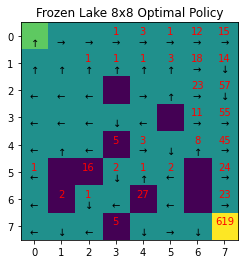

In [58]:
# Get grid in terms of Hole:-1, F:0, G:1
lake = np.zeros((grid_size, grid_size))
for (x,y), el in np.ndenumerate(env.desc):
    if el == b'S':
        lake[x,y] = .5
    elif el == b'H':
        lake[x,y] = -1
    elif el == b'G':
        lake[x,y] = 1

fig, ax = plt.subplots()
ax.imshow(lake)    

ax.set_xticks(np.arange(grid_size))
ax.set_yticks(np.arange(grid_size))
# 
locs = [(idx // grid_size, idx % grid_size) for idx in histogram.keys()]
for key, val in histogram.items():
    loc = (key // grid_size, key % grid_size)
    ax.text(loc[1], loc[0], val,
        ha='center', va='bottom', color='r')

for (y,x), a in np.ndenumerate(opt_action):
    if a == 'UP':
        txt = r"$\uparrow$"
    elif a == 'RIGHT':
        txt = r"$\rightarrow$"
    elif a == 'LEFT':
        txt = r"$\leftarrow$"
    elif a == 'DOWN':
        txt = r"$\downarrow$"
    if lake[y,x] in (-1, 1):
        continue
    ax.text(x, y, txt, ha='center', va='top')

ax.set_title(f"Frozen Lake {MAP_SIZE} Optimal Policy");